<a href="https://colab.research.google.com/github/moshebou/ML-Bootcamp/blob/master/AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# general imports
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

## Auto Encoders

### Background
Autoencoder is a neural network designed to learn an identity function in an unsupervised way to reconstruct the original input while compressing the data in the process so as to discover a more efficient and compressed representation. The idea was originated in the 1980s, and later promoted by the seminal paper by Hinton & Salakhutdinov, 2006.


###   Basic architecture
It consists of two networks:


1.   Encoder network: It translates the original high-dimension input into the latent low-dimensional code. The input size is larger than the output size.

2.   Decoder network: The decoder network recovers the data from the code, likely with larger and larger output layers.

#### Fig. 1. Illustration of autoencoder model architecture
![Fig. 1. Illustration of autoencoder model architecture.](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)

###   Varitation to AE

Autoencoder is a method for dimantinality reduction.
Autoencoders are commonly used for compression, feature selection and extraction. \\
However, since the autoencoder learns the identity function, we are facing the risk of “overfitting” when there are more network parameters than the number of data points.

#### **Denoising autoencoder**

One suggested solution is the denoising autoencoder (Vincent et al. 2008), which trains on a noisy version of the input.
This modification helps avoid overfit, and makes the bottlenexk $z$ more semantic. In the paper, the noise which was used was a form of salt and paper noise, which has similar nature as drop-out. 
#### Fig. 2. Illustration of denoising autoencoder model architecture.
![Fig. 2. Illustration of denoising autoencoder model architecture.](https://lilianweng.github.io/lil-log/assets/images/denoising-autoencoder-architecture.png)

#### **k-Sparse Autoencoder**
In k-Sparse Autoencoder (Makhzani and Frey, 2013) , the sparsity is enforced by only keeping the top k highest activations in the bottleneck layer with linear activation function.
#### Fig. 3. Filters of the k-sparse autoencoder for different sparsity levels k, learnt from MNIST with 1000 hidden units. (Image source: Makhzani and Frey, 2013)
![Fig. 3.  Filters of the k-sparse autoencoder for different sparsity levels k, learnt from MNIST with 1000 hidden units. (Image source: Makhzani and Frey, 2013)](
https://lilianweng.github.io/lil-log/assets/images/k-sparse-autoencoder.png)

### Code example

In [15]:
# dataset handline
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(
  root="~/torch_datasets", train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.MNIST(
  root="~/torch_datasets", train=False, transform=transform, download=True
)
train_loader = torch.utils.data.DataLoader(
  train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
  test_dataset, batch_size=32, shuffle=False, num_workers=4
)

In [30]:
class Reshape(nn.Module):
  def __init__(self, channels, width, height=None):
    self.width = width
    if height is not None:
      self.height = height
    else:
      self.height = width
    self.channels = channels
    super(Reshape, self).__init__()

  def forward(self, input):
    return torch.reshape(input, (input.shape[0], self.channels, self.width, self.height))

class Flatten(nn.Module):
  def forward(self, input):
    return input.view(input.shape[0], -1)
# simplest nn - conv transpose
class AE_model(nn.Module):
  def __init__(self):
    super(AE_model, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 64, 3, stride=2, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros'),
      nn.LeakyReLU(0.3),
      nn.Conv2d(64, 128, 4, stride=2, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros'),
      nn.LeakyReLU(0.3),
      Flatten(), 
      nn.Linear(128*7*7, 64),
      nn.Tanh()
    )
    self.decoder = nn.Sequential(
      nn.Linear(64, 128*7*7),
      Reshape(128, 7, 7),
      nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros'),
      nn.LeakyReLU(0.3),
      nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros'),
      nn.Sigmoid()
    )

  def forward(self, x):
    z = self.encoder(x)
    return self.decoder(z)

start epoch 0


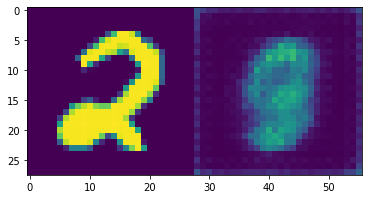

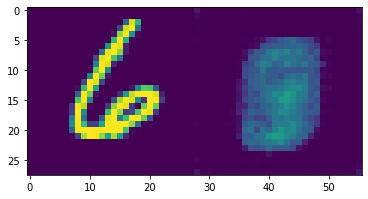

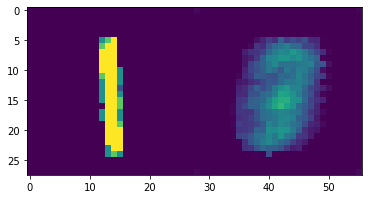

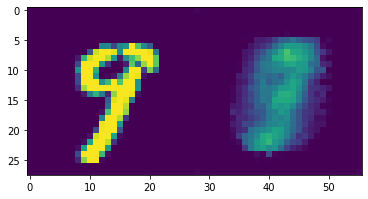

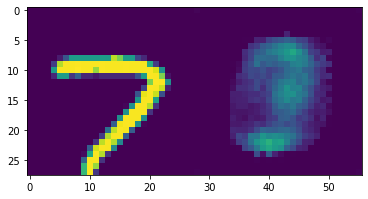

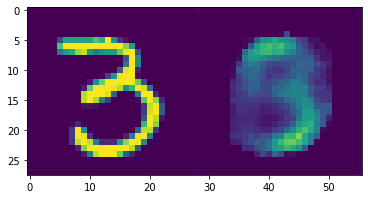

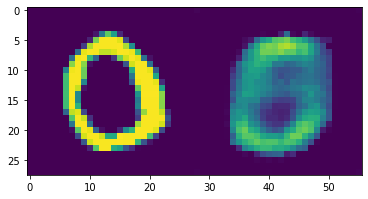

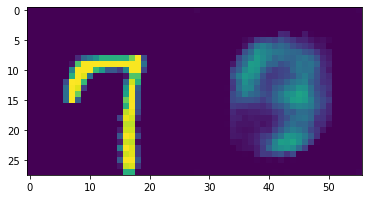

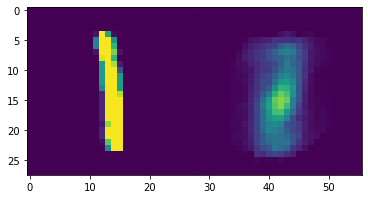

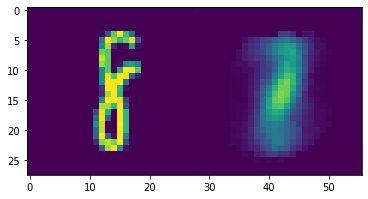

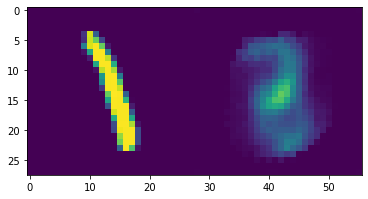

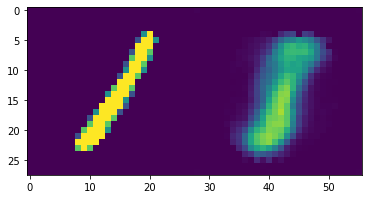

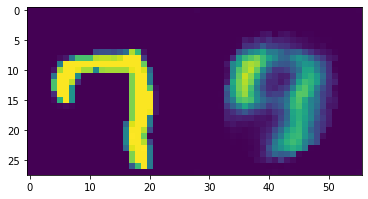

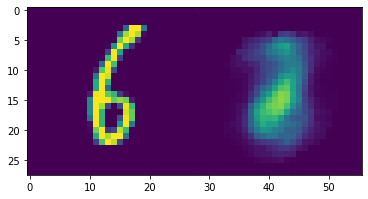

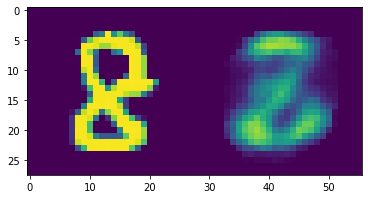

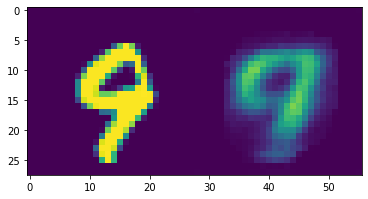

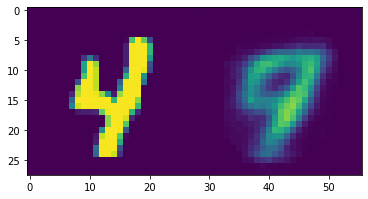

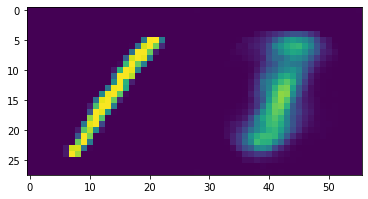

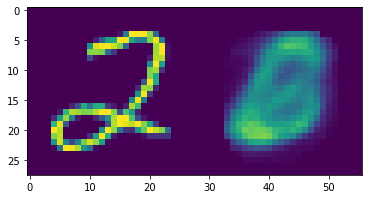

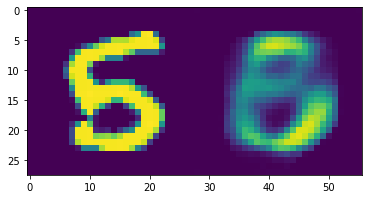

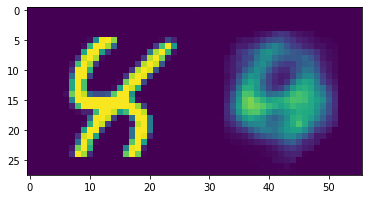

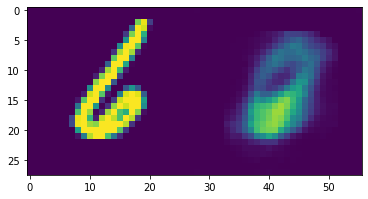

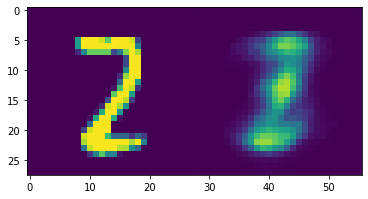

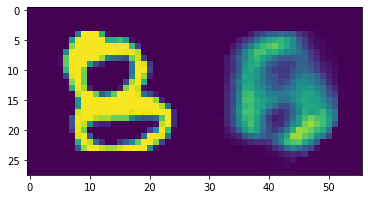

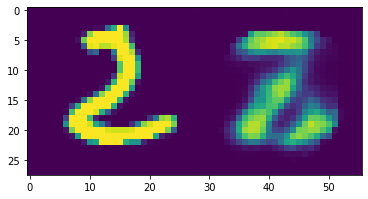

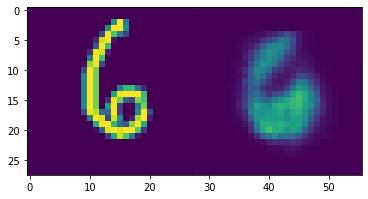

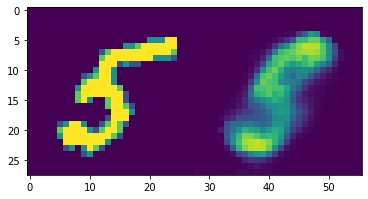

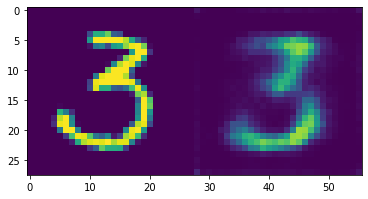

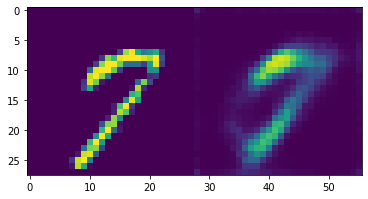

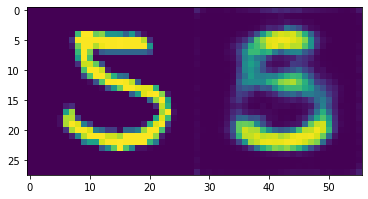

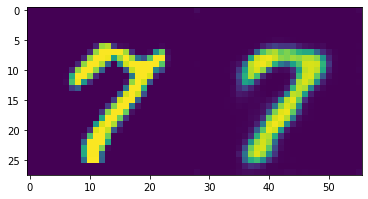

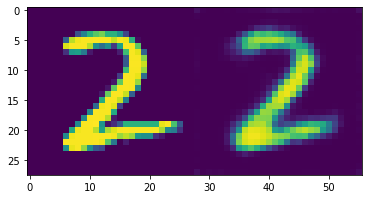

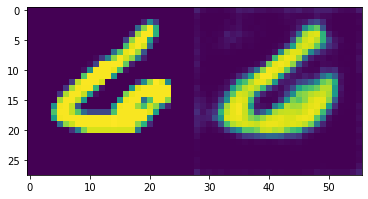

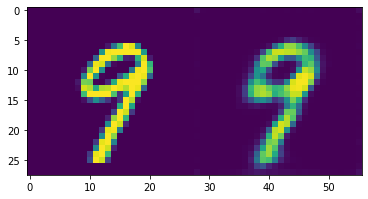

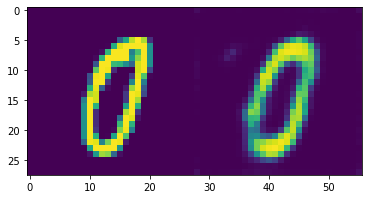

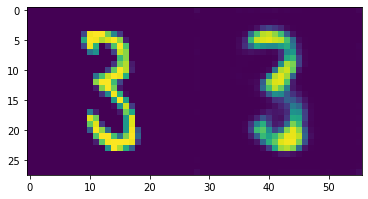

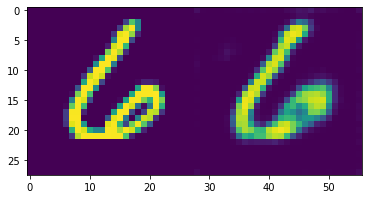

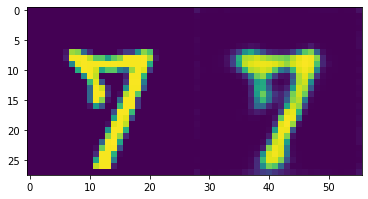

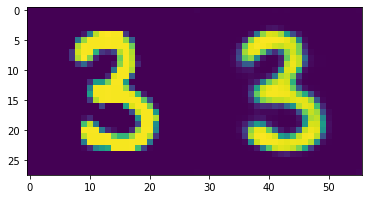

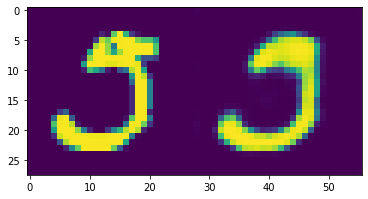

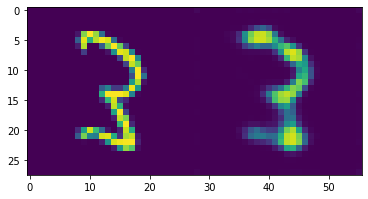

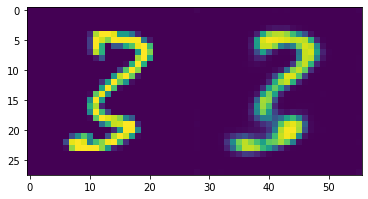

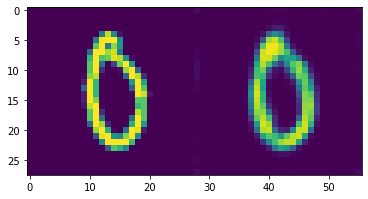

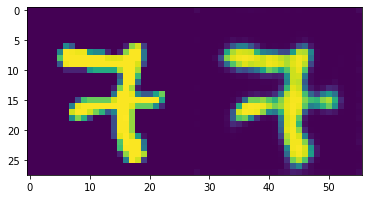

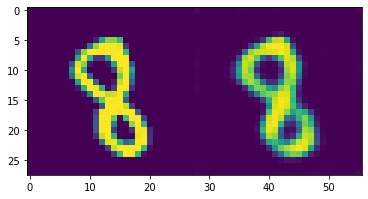

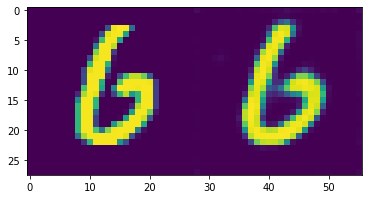

epoch : 1/1, loss = 0.036579


In [37]:
epochs = 1
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE_model().to(device)
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# mean-squared error loss
criterion = nn.MSELoss()
model.train()
for epoch in range(epochs):
    loss = 0
    print("start epoch %d"%epoch)
    for i, (batch_features, _) in enumerate(train_loader):
        if i >0 and i %10 == 0:
          plt.figure()
          vis = np.concatenate((batch_features.detach().numpy()[0, 0, :, :], model(batch_features).detach().numpy()[0, 0, :, :]), axis=1)
          plt.imshow(vis)
          plt.draw()
          plt.show()
        # load it to the active device
        batch_features = batch_features.to(device)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        # compute reconstructions
        outputs = model(batch_features)
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        # compute accumulated gradients
        train_loss.backward()
        # perform parameter update based on current gradients
        optimizer.step()
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    # compute the epoch training loss
    loss = loss / len(train_loader)
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

# Reference

*   [Lilian Weng github blog](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)
*   [Ahlad Kumar Youtube channel](https://www.youtube.com/watch?v=w8F7_rQZxXk&list=PLdxQ7SoCLQANizknbIiHzL_hYjEaI-wUe)